In [101]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torchmin import minimize
from scipy.stats import chi2

In [102]:
# Parameters
num_patients = 200

#unknown parameters
mean_test_score = 40 # fixed intercept
b_1 = -8.0 # effect of affected family
b_2 = 0.0 # effect of sex 
noise_var = 0.1 # variance of noise
var_time_effect = 1.0
var_intercept = 1.0

# Generate data
data = []
ground_truth = []

for i in range(num_patients):
    time_points = []
    while len(time_points) < 5:
        length = np.random.uniform(4, 10)
        time_points = np.sort([np.random.uniform(0, length) for i in range(int(length) + 2)])
        time_points = time_points[np.diff(np.concatenate(([0.], time_points))) > 0.25]

    # draw fixed effect characteristics
    family_affected = np.random.binomial(1, 0.6)  # 1 for family affected, 0 for not affected
    sex = np.random.binomial(1, 0.5)  # 1 for male, 0 for female   
    
    # draw random effects
    time_effect = np.random.normal(0.0, np.sqrt(var_time_effect))
    random_intercept = np.random.normal(0.0, np.sqrt(var_intercept))

    for j,t in enumerate(time_points):
        # draw noise
        noise = np.random.normal(0.0, np.sqrt(noise_var))

        # simulate patient trajectories
        score = mean_test_score + \
                b_1 * family_affected + \
                b_2 * sex + \
                random_intercept + \
                time_effect * t + \
                noise 
                
        data.append([i, t, family_affected, sex, score])


df = pd.DataFrame(data, columns=['patient_id', 'years_after_treatment', 'family_affected', 'sex', 'test_score'])


      patient_id  years_after_treatment  family_affected  sex  test_score
0              0               0.541159                1    0   32.035680
1              0               1.605612                1    0   31.290735
2              0               3.004351                1    0   29.949560
3              0               4.040294                1    0   29.480427
4              0               6.050985                1    0   28.010368
...          ...                    ...              ...  ...         ...
1366         199               3.180759                0    0   37.667610
1367         199               3.692665                0    0   37.036358
1368         199               5.001742                0    0   36.077070
1369         199               7.141471                0    0   35.263411
1370         199               7.491811                0    0   34.455195

[1371 rows x 5 columns]


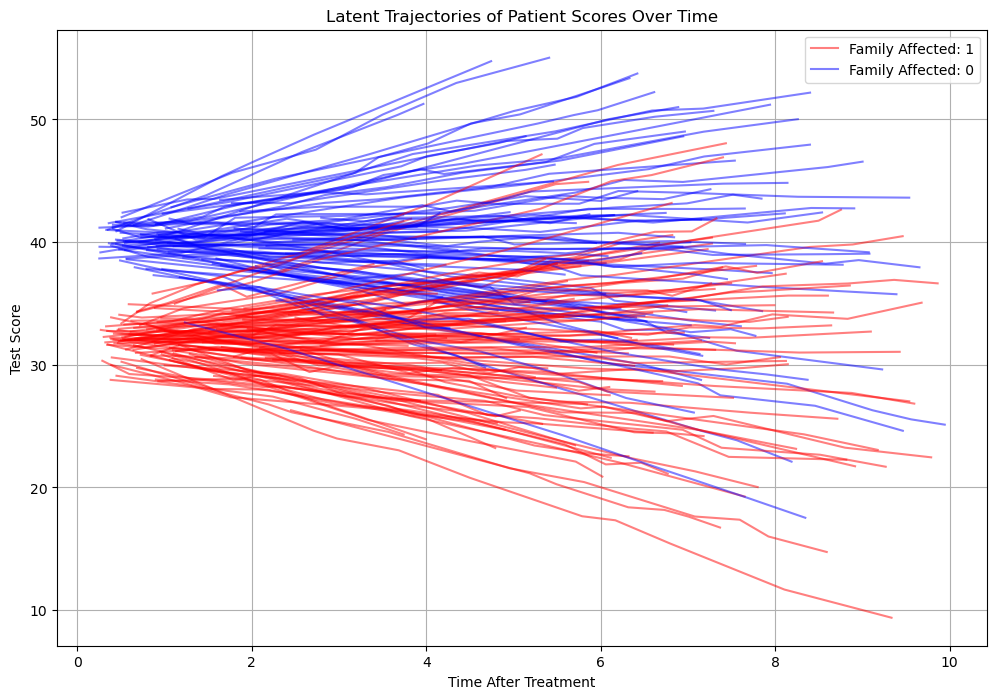

In [103]:
# plot the dataset

color_effect = 'family_affected' #sex 

# Assuming you have your data in a DataFrame named 'df'
marker_map = {0: 'blue', 1: 'red'} 

plt.figure(figsize=(12, 8))
# Create a set to track which labels have already been added to the legend
added_labels = set()

for patient_id in df['patient_id'].unique():
    patient_data = df[df['patient_id'] == patient_id]
    
    label = patient_data[color_effect].iloc[0]
    color = marker_map[label]

    # Check if the label has been added to the legend
    if label not in added_labels:
        plt.plot(patient_data['years_after_treatment'], patient_data['test_score'],
                 alpha=0.5, color=color, label=f'Family Affected: {label}')
        added_labels.add(label)
    else:
        plt.plot(patient_data['years_after_treatment'], patient_data['test_score'],
                 alpha=0.5, color=color)

plt.title('Latent Trajectories of Patient Scores Over Time')
plt.xlabel('Time After Treatment')
plt.ylabel('Test Score')
plt.grid(True)
plt.legend()
plt.show()


In [104]:
def get_ind(pat,df):
    return np.where(df['patient_id'] == pat)[0]
# Random effects design matrix (Datenmatrix) for each patient
def calculate_Zlist(df, random_effects_keys):
    Z_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), random_effects_keys]))
                        ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return Z_list

# Fixed effects design matrix (Datenmatrix) for each patient
def calculate_Xlist(df, fixed_effects_keys):
    X_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), fixed_effects_keys]))
                         ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return X_list

def likelihood_ratio_test(L1, L2):
    return 2 * (L2 - L1)

# returns a block diagonal matrix of a list of matrices
def block_diag_list(arrs_list):
    shape = torch.sum(torch.tensor([a.shape for a in arrs_list], dtype=torch.int32), dim=0)
    dtype = arrs_list[0].dtype
    device = arrs_list[0].device

    out = torch.zeros(*shape.tolist(), dtype=dtype, device=device)

    r, c = 0, 0
    for a in arrs_list:
        rows, cols = a.shape
        out[r:r + rows, c:c + cols] = a
        r += rows
        c += cols
    return out

In [105]:
#keys for random and fixed effects in the matrix
fixed_effects_keys = ['family_affected', 'sex']
random_effects_keys = ['years_after_treatment']

n_fixed_eff = len(fixed_effects_keys) + 1
n_rand_eff = len(random_effects_keys) + 1
N = len(df)

# Random effects design matrix (Datenmatrix) for each patient
Z_list = calculate_Zlist(df, random_effects_keys)

# Fixed effects design matrix (Datenmatrix) for each patient
X_list = calculate_Xlist(df, fixed_effects_keys)

# Response variable: Test scores
y = torch.from_numpy(np.array(df['test_score'])).to(torch.float32)

softplus = torch.nn.Softplus()

# Learnable parameter for diagonal covariance matrix
D_param = torch.randn(n_rand_eff, requires_grad=True)


# Defining list of X tilde (eq. 2.7 p. 63)
X_tilde_list = [torch.cat((X_i, torch.zeros((n_rand_eff, n_fixed_eff)))) for X_i in X_list]
# Augmented response vector y_e (eq. 2.11 p. 65)
y_e = torch.cat([torch.cat((y[get_ind(pat, df)], torch.zeros(n_rand_eff))).unsqueeze(-1) for pat in df['patient_id'].unique()])


def calculate_likelihood(D_param): 
    # Ensure that the diagonal covariance matrix has only positive values
    Delta = torch.diag(softplus(D_param))
    det_Delta = torch.det(Delta)  

    # Defining list of Z tilde (eq. 2.7 p. 63)
    Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list]
    # Matrix X_e (eq. 2.11 p. 65)
    X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list)), -1)

    # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
    pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e
    # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
    pred_sigma = torch.sum((y_e - X_e @ pred) ** 2) / N

    # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
    likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
    likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
    print(f"Likelihood: {round(likelihood.item(), 2)}, est. noise: {round(pred_sigma.item(), 3)}, est. fixed intercept: {round(pred[-n_fixed_eff].detach().item(), 3)}, "+ \
        ", ".join([f"est. {fixed_effects_keys[i]}: {round(pred[-n_fixed_eff+i+1].detach().item(), 3)}" for i in range(len(fixed_effects_keys))]))
    return - likelihood

# Minimize the log-likelihood with 2nd order optimizer
result = minimize(calculate_likelihood, D_param, method='bfgs', max_iter=6)

likelihood_df = calculate_likelihood(D_param)

# Alternative: Minimize the log-likelihood with 1st order optimizer
#optimizer = Adam([D_param], lr=0.1)
#for i in range(100):
#    optimizer.zero_grad()
#    likelihood = calculate_likelihood(D_param)
#    likelihood.backward() 
#    optimizer.step()  


Likelihood: -1953.04, est. noise: 0.386, est. fixed intercept: 40.303, est. family_affected: -8.101, est. sex: -0.408
Likelihood: -1616.95, est. noise: 0.215, est. fixed intercept: 40.298, est. family_affected: -8.118, est. sex: -0.352
Likelihood: -2106.49, est. noise: 0.082, est. fixed intercept: 40.296, est. family_affected: -8.139, est. sex: -0.304
Likelihood: -1388.09, est. noise: 0.102, est. fixed intercept: 40.294, est. family_affected: -8.131, est. sex: -0.312
Likelihood: -1381.27, est. noise: 0.107, est. fixed intercept: 40.295, est. family_affected: -8.131, est. sex: -0.315
Likelihood: -1381.04, est. noise: 0.108, est. fixed intercept: 40.295, est. family_affected: -8.131, est. sex: -0.315
Likelihood: -1381.04, est. noise: 0.108, est. fixed intercept: 40.296, est. family_affected: -8.131, est. sex: -0.315
Likelihood: -1381.04, est. noise: 0.108, est. fixed intercept: 40.296, est. family_affected: -8.131, est. sex: -0.315
Likelihood: -1953.04, est. noise: 0.386, est. fixed inte